Best CV params: {'knn__metric': 'minkowski', 'knn__n_neighbors': 3, 'knn__p': 1, 'knn__weights': 'uniform'}
Best CV accuracy: 0.9714285714285715

Test accuracy: 0.9649122807017544

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.93      0.95        42
           1       0.96      0.99      0.97        72

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



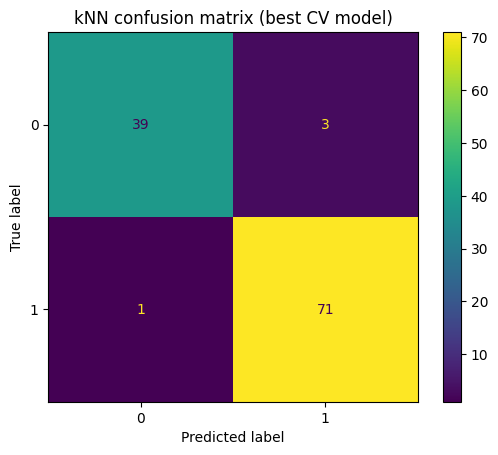

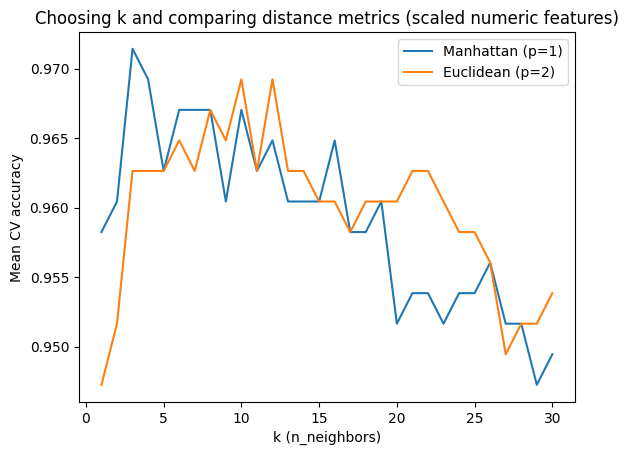


Text example prediction: 0
Class probabilities: [0.7906107 0.2093893]

Cosine distances to training samples: [0.936 1.    0.343 0.752 0.889 0.933]
Nearest indices: [2 3 4]


In [1]:
# kNN Tutorial Notebook: choosing k + metric

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Numeric dataset demo
X, y = load_breast_cancer(return_X_y=True)

# Hold out a test set for a final, unbiased evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Pipeline ensures scaling happens inside CV folds (prevents leakage)
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

# Grid: choose k and compare Euclidean (p=2) vs Manhattan (p=1)
param_grid = {
    "knn__n_neighbors": list(range(1, 31)),
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["minkowski"],
    "knn__p": [1, 2]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    refit=True,
    return_train_score=True
)

search.fit(X_train, y_train)

print("Best CV params:", search.best_params_)
print("Best CV accuracy:", search.best_score_)

# Evaluate on the untouched test set
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)

print("\nTest accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.title("kNN confusion matrix (best CV model)")
plt.show()

# Plot mean CV accuracy vs k for p=1 and p=2 (best weights per setting)
results = search.cv_results_
ks = np.array(results["param_knn__n_neighbors"].data, dtype=int)
ps = np.array(results["param_knn__p"].data, dtype=int)
weights = np.array(results["param_knn__weights"].data, dtype=str)
mean_test = np.array(results["mean_test_score"])

def best_curve_for_p(p_value):
    curve = []
    for k in range(1, 31):
        mask = (ks == k) & (ps == p_value)
        # pick best among weights for that (k, p)
        curve.append(mean_test[mask].max())
    return np.array(curve)

curve_p1 = best_curve_for_p(1)
curve_p2 = best_curve_for_p(2)

plt.plot(range(1, 31), curve_p1, label="Manhattan (p=1)")
plt.plot(range(1, 31), curve_p2, label="Euclidean (p=2)")
plt.xlabel("k (n_neighbors)")
plt.ylabel("Mean CV accuracy")
plt.title("Choosing k and comparing distance metrics (scaled numeric features)")
plt.legend()
plt.show()

# Text demo with cosine metric
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances

texts = [
    "refund was fast and support was helpful",
    "customer service helped me get a refund quickly",
    "the battery life is terrible and the screen is dim",
    "awful battery, poor display quality",
    "love the camera and the battery lasts all day",
    "excellent camera, great battery performance"
]
labels = np.array([1, 1, 0, 0, 1, 1])  # toy sentiment-like labels (1=positive-ish, 0=negative-ish)

# TF-IDF -> cosine distance (angle-based). For sparse TF-IDF, cosine is often sensible.
tfidf = TfidfVectorizer(norm="l2")
X_txt = tfidf.fit_transform(texts)

# scikit-learn's KNeighborsClassifier expects a metric string;
# it supports "cosine" through pairwise distances.
knn_cos = KNeighborsClassifier(n_neighbors=3, metric="cosine", weights="distance")
knn_cos.fit(X_txt, labels)

query = ["battery is bad and screen is awful"]
X_q = tfidf.transform(query)
pred = knn_cos.predict(X_q)[0]
proba = knn_cos.predict_proba(X_q)[0]

print("\nText example prediction:", pred)
print("Class probabilities:", proba)

# Optional: inspect cosine distances to training points for transparency
d = cosine_distances(X_q, X_txt).ravel()
print("\nCosine distances to training samples:", np.round(d, 3))
print("Nearest indices:", np.argsort(d)[:3])